### HW 5 Мельчук Андрей

## Практическое задание

<ol>
    <li>Попробуйте изменить параметры нейронной сети работающей с датасетом imdb либо нейронной сети работающей airline-passengers(она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить ее точность. Приложите анализ.</li>
    <li>Попробуйте изменить параметры нейронной сети генерирующий текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший получившейся у вас текст и опишите, что вы предприняли, чтобы его получить. Можно использовать текст другого прозведения.</li>
    <li>* Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
    <li>* Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

#### 1. IMDB

https://keras.io/examples/imdb_lstm/

In [17]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

Using TensorFlow backend.


In [26]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')


Loading data...
25000 train sequences
25000 test sequences


In [36]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [37]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 256))
model.add(LSTM(256, dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

Build model...


In [38]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)

print('Test accuracy:', acc)

Train...


C:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 264s 11ms/step - loss: 0.4799 - accuracy: 0.7702 - val_loss: 0.4193 - val_accuracy: 0.8224
Epoch 2/2
25000/25000 [==============================] - 62s 2ms/step
Test score: 0.3765051734161377
Test accuracy: 0.8362799882888794


    При LTSM/Embedding 128
    Test score: 0.4506777255535126
    Test accuracy: 0.823360025882721
    
    Как видно, увеличение количества LTSM блоков до 256 качества сильно не прибавляет, 
    а время вычисления увеличивает заметно.
    Большее число фичей Embedding положительно влияет на качество, но скорость вычисления так же падает.
    Увеличение dropout=0.25, recurrent_dropout = 0.25 чуть ухудшило качество по сравнению со значением .2 .

### 2. ALICE IN WONDERLAND

In [107]:
import numpy as np
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import l1


# построчное чтение из примера с текстом 
with open("alice_in_wonderland.txt", 'rb') as _in:
    lines = []
    for line in _in:
        line = line.strip().lower().decode("ascii", "ignore")
        if len(line) == 0:
            continue
        lines.append(line)
text = " ".join(lines)
chars = set([c for c in text])
nb_chars = len(chars)


# создание индекса символов и reverse mapping чтобы передвигаться между значениями numerical
# ID and a specific character. The numerical ID will correspond to a column
# ID и определенный символ. Numerical ID будет соответсвовать колонке
# число при использовании one-hot кодировки для представление входов символов
char2index = {c: i for i, c in enumerate(chars)}
index2char = {i: c for i, c in enumerate(chars)}

# для удобства выберете фиксированную длину последовательность 10 символов 
SEQLEN, STEP = 10, 1
input_chars, label_chars = [], []

# конвертация data в серии разных SEQLEN-length субпоследовательностей
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i: i + SEQLEN])
    label_chars.append(text[i + SEQLEN])


# Вычисление one-hot encoding входных последовательностей X и следующего символа (the label) y

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1


# установка ряда метапамертров  для нейронной сети и процесса тренировки
BATCH_SIZE, HIDDEN_SIZE = 128, 128
NUM_ITERATIONS = 100 # 25 должно быть достаточно
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 120


# Create a super simple recurrent neural network. There is one recurrent
# layer that produces an embedding of size HIDDEN_SIZE from the one-hot
# encoded input layer. This is followed by a Dense fully-connected layer
# across the set of possible next characters, which is converted to a
# probability score via a standard softmax activation with a multi-class
# cross-entropy loss function linking the prediction to the one-hot
# encoding character label.

'''
Создание очень простой рекуррентной нейронной сети. В ней будет один реккурентный закодированный входной слой. За ним последует полносвязный слой связанный с набором возможных следующих символов, которые конвертированы в вероятностные результаты через стандартную softmax активацию с multi-class cross-encoding loss функцию ссылающуются на предсказание one-hot encoding лейбл символа
'''

model = Sequential()
model.add(
    LSTM(  # вы можете изменить эту часть на LSTM или SimpleRNN, чтобы попробовать альтернативы
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(SEQLEN, nb_chars),
#         dropout=0.05,
#         activity_regularizer=l1(0.001),
        unroll=True
    )
)
model.add(Dense(nb_chars))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam") #rmsprop


# выполнение серий тренировочных и демонстрационных итераций 
for iteration in range(NUM_ITERATIONS):

    # для каждой итерации запуск передачи данных в модель 
    print("=" * 50)
    print("Итерация #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Select a random example input sequence.
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    # для числа шагов предсказаний использование текущей тренируемой модели 
    # конструирование one-hot encoding для тестирования input и добавление предсказания.
    print("Генерация из посева: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):

        # здесь one-hot encoding.
        X_test = np.zeros((1, SEQLEN, nb_chars))
        for j, ch in enumerate(test_chars):
            X_test[0, j, char2index[ch]] = 1

        # осуществление предсказания с помощью текущей модели.
        pred = model.predict(X_test, verbose=0)[0]
        y_pred = index2char[np.argmax(pred)]

        # вывод предсказания добавленного к тестовому примеру 
        print(y_pred, end="")

        # инкрементация тестового примера содержащего предсказание
        test_chars = test_chars[1:] + y_pred
print()


Итерация #: 0
Epoch 1/1
158773/158773 [==============================] - 20s 127us/step - loss: 2.4826
Генерация из посева: walked off
walked off the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the==================================================
Итерация #: 1
Epoch 1/1
158773/158773 [==============================] - 19s 123us/step - loss: 2.0545
Генерация из посева: re might b
re might be the was in a dont it and the made the pare and the pare and the pare and the pare and the pare and the pare and the pa==================================================
Итерация #: 2
Epoch 1/1
158773/158773 [==============================] - 20s 127us/step - loss: 1.8797
Генерация из посева: is, she ca
is, she cand the mack the mack the mack the mack the mack the mack the mack the mack the mack the mack the mack the mack the mack ==================================================
Итерация #: 3
Epoch 1/1
158773/158773 [=============

158773/158773 [==============================] - 20s 128us/step - loss: 1.0699
Генерация из посева: like, but 
like, but the mouse was the mouse was the mouse was the mouse was the mouse was the mouse was the mouse was the mouse was the mous==================================================
Итерация #: 27
Epoch 1/1
158773/158773 [==============================] - 20s 123us/step - loss: 1.0583
Генерация из посева: hat they c
hat they cant her hands of course it would be no doesnt go on with the duchess was a little sharply and the poor little thing is a==================================================
Итерация #: 28
Epoch 1/1
158773/158773 [==============================] - 19s 123us/step - loss: 1.0451
Генерация из посева: ern, with 
ern, with a baby with its eyes, and the dormouse shook his the best cater if it was the door of the project gutenberg-tm electroni==================================================
Итерация #: 29
Epoch 1/1
158773/158773 [==============================] - 

158773/158773 [==============================] - 20s 128us/step - loss: 0.8400
Генерация из посева: r tongue, 
r tongue, said alice, and she went on again, alice thought the poor his head out the round she heard a little way off, and began s==================================================
Итерация #: 53
Epoch 1/1
158773/158773 [==============================] - 20s 126us/step - loss: 0.8338
Генерация из посева: t.  if you
t.  if you dont let me supld as she could not off, said the caterpillar took the house, the mock turtle, said the caterpillar took==================================================
Итерация #: 54
Epoch 1/1
158773/158773 [==============================] - 20s 128us/step - loss: 0.8270
Генерация из посева: ell, if i 
ell, if i no roke. then herepted to see if the popide a finis ebooks, and she dread behowing that she said to herself, and off wit==================================================
Итерация #: 55
Epoch 1/1
158773/158773 [==============================] - 

158773/158773 [==============================] - 20s 124us/step - loss: 0.7209
Генерация из посева: n i learn 
n i learn of the tea-pittlen alise--bole, and she starps cook to knew the mouse to the conchuprantle she he one, said alice, and s==================================================
Итерация #: 79
Epoch 1/1
158773/158773 [==============================] - 20s 127us/step - loss: 0.7173
Генерация из посева: t to bring
t to bring peet in a far out to the little golden key was the duchess said again! said alice, as she was a little bitllente a shro==================================================
Итерация #: 80
Epoch 1/1
158773/158773 [==============================] - 20s 124us/step - loss: 0.7153
Генерация из посева:  with that
 with that she was now am not a good deal for enting trisled down the hatter was the white rabbit, who seemed to be nothing more t==================================================
Итерация #: 81
Epoch 1/1
158773/158773 [==============================] - 

#### Результат

В итоге лучшее предложение,

"personal remarks beater-- you couldnt tell what a dited the gryphon replied rather anxiously at the duchess, and the little pitte"

"личные реплики, ты не мог бы сказать, что грифон довольно беспокойно ответил на герцогиню и маленькую питте"

Увеличениие BATCH_SIZE, HIDDEN_SIZE не помогло. А вот большее число итераций улучшает результат и позволяет стоить все более хитрые предложения.

### 3. LSTM on numpy

Как реализовано, изучил отсюда. 

https://blog.varunajayasiri.com/numpy_lstm.html

Сеть обучается с использованием стохастического градиентного спуска с использованием алгоритма AdaGrad.

In [85]:
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

In [86]:
data = open("alice_in_wonderland.txt", 'r').read()

In [87]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 163815 characters, 86 unique


In [88]:
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [89]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

In [90]:
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

In [91]:
class Parameters:    
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [92]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [93]:
def backward(target, dh_next, dC_next, C_prev,
    z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [94]:
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

In [95]:
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [96]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [97]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [98]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [99]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

In [100]:
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [101]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

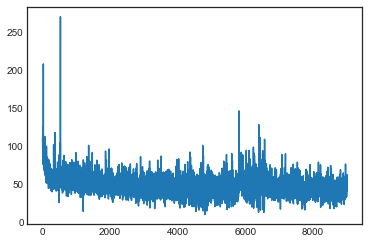

----
 maal; on knowaat outse
quitt heingh,’s ‘and and
a canither”.

And as are to timen heating the he muchertabilly in a tmeak an ioghto
doven tumping at begusteny agean if leag
was bothabed, and the Hoome 
----
iter 9004, loss 44.350002


In [102]:
# Training loop
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

    Модель обычно достигает ошибки около 44 после 9000 итераций при тестировании с выборкой из 100 000 символов. 
    Однако это иногда застревает в локальных минимумах.

### 4 Gradient

Можно проверить, равны ли приблизительные градиенты расчетным аналитическим градиентам (путем backpropagation).

In [103]:
from random import uniform

In [104]:
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

In [105]:
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [106]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_f (6.958984e-05, 6.958928e-05) => 4.062088e-06
W_f (6.828316e-07, 6.827892e-07) => 3.102695e-05
W_f (-8.668621e-08, -8.622852e-08) => 2.631697e-03
W_i (1.029541e-05, 1.029518e-05) => 1.104474e-05
W_i (4.921432e-05, 4.921377e-05) => 5.562066e-06
W_C (1.601755e-04, 1.601747e-04) => 2.441997e-06
W_v (8.407142e-06, 8.407344e-06) => 1.202627e-05
W_v (3.378631e-07, 3.381434e-07) => 4.140422e-04
W_v (-1.154632e-06, -1.154463e-06) => 7.301813e-05
b_f (-4.919702e-03, -4.919642e-03) => 6.050972e-06
b_f (-2.004849e-02, -2.004842e-02) => 1.609175e-06
b_f (-2.004849e-02, -2.004842e-02) => 1.609175e-06
b_f (6.435485e-02, 6.435280e-02) => 1.596124e-05
b_i (-6.419242e-02, -6.419222e-02) => 1.540923e-06
b_i (-8.623683e-02, -8.623656e-02) => 1.542887e-06
b_i (-2.885017e-02, -2.885011e-02) => 1.055722e-06
b_i (-2.882515e-02, -2.882525e-02) => 1.676248e-06
b_i (1.994857e-02, 1.994862e-02) => 1.087268e-06
b_i (1.948465e-02, 1.948470e-02) => 1.289304e-06
b_o (-1.599535e-01, -1.599555e-01) => 6.214903e-06


### Способы борьбы с исчезающим градиентом в RNN

Нашел теорию тут,

https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577

Долгосрочные зависимости и отношения кодируются в векторах состояния ячейки, и именно производная состояния ячейки может предотвратить исчезновение градиентов LSTM. 


